In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow import keras
from keras._tf_keras.keras import layers, models, callbacks, preprocessing
Sequential = models.Sequential
LSTM = layers.LSTM
Dense = layers.Dense
Dropout = layers.Dropout

EarlyStopping = callbacks.EarlyStopping
ReduceLROnPlateau = callbacks.ReduceLROnPlateau

TimeseriesGenerator = preprocessing.sequence.TimeseriesGenerator

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10



In [20]:
print("1. CARGA Y EXPLORACIÓN DE DATOS")
print("-" * 40)

# Opción 1: Cargar datos usando pandas-datareader (recomendado)
try:
    from pandas_datareader import data as pdr
    
    # Configurar fechas
    start_date = datetime(1992, 1, 1)
    end_date = datetime(2024, 12, 31)
    
    # Descargar datos de FRED
    print("Descargando datos de FRED...")
    df = pdr.get_data_fred('IPN31152N', start_date, end_date)
    print("Datos descargados exitosamente desde FRED")
    
except ImportError:
    print("pandas-datareader no disponible. Usando datos de ejemplo...")
    # Crear datos sintéticos que simulen la serie temporal
    dates = pd.date_range(start='1992-01-01', end='2024-12-31', freq='M')
    # Simular tendencia + estacionalidad + ruido
    trend = np.linspace(80, 120, len(dates))
    seasonal = 10 * np.sin(2 * np.pi * np.arange(len(dates)) / 12) + 5 * np.cos(4 * np.pi * np.arange(len(dates)) / 12)
    noise = np.random.normal(0, 3, len(dates))
    values = trend + seasonal + noise
    df = pd.DataFrame(values, index=dates, columns=['IPN31152N'])

# Mostrar información básica
print(f"\nInformación del dataset:")
print(f"- Período: {df.index[0].strftime('%Y-%m-%d')} a {df.index[-1].strftime('%Y-%m-%d')}")
print(f"- Total de observaciones: {len(df)}")
print(f"- Frecuencia: Mensual")
print(f"- Variable: Índice de Producción Industrial (Base 2012=100)")

1. CARGA Y EXPLORACIÓN DE DATOS
----------------------------------------
Descargando datos de FRED...
Datos descargados exitosamente desde FRED

Información del dataset:
- Período: 1992-01-01 a 2024-12-01
- Total de observaciones: 396
- Frecuencia: Mensual
- Variable: Índice de Producción Industrial (Base 2012=100)


In [21]:
print(f"Estadísticas descriptivas:")
print(df.describe())

# Verificar valores faltantes
missing_values = df.isnull().sum().iloc[0]
print(f"\nValores faltantes: {missing_values}")

if missing_values > 0:
    print("Rellenando valores faltantes usando interpolación lineal...")
    df = df.interpolate(method='linear')
    print("Valores faltantes rellenados")

# Mostrar primeras y últimas observaciones
print(f"\nPrimeras 5 observaciones:")
print(df.head())
print(f"\nÚltimas 5 observaciones:")
print(df.tail())

Estadísticas descriptivas:
        IPN31152N
count  396.000000
mean   120.385231
std     25.183040
min     68.060900
25%    102.564700
50%    117.626700
75%    136.748625
max    196.817400

Valores faltantes: 0

Primeras 5 observaciones:
            IPN31152N
DATE                 
1992-01-01    90.5020
1992-02-01   110.7500
1992-03-01   131.8723
1992-04-01   135.6330
1992-05-01   143.2355

Últimas 5 observaciones:
            IPN31152N
DATE                 
2024-08-01   124.7476
2024-09-01   111.0717
2024-10-01   105.3919
2024-11-01    91.3876
2024-12-01    89.3572


2. VISUALIZACIÓN EXPLORATORIA
----------------------------------------


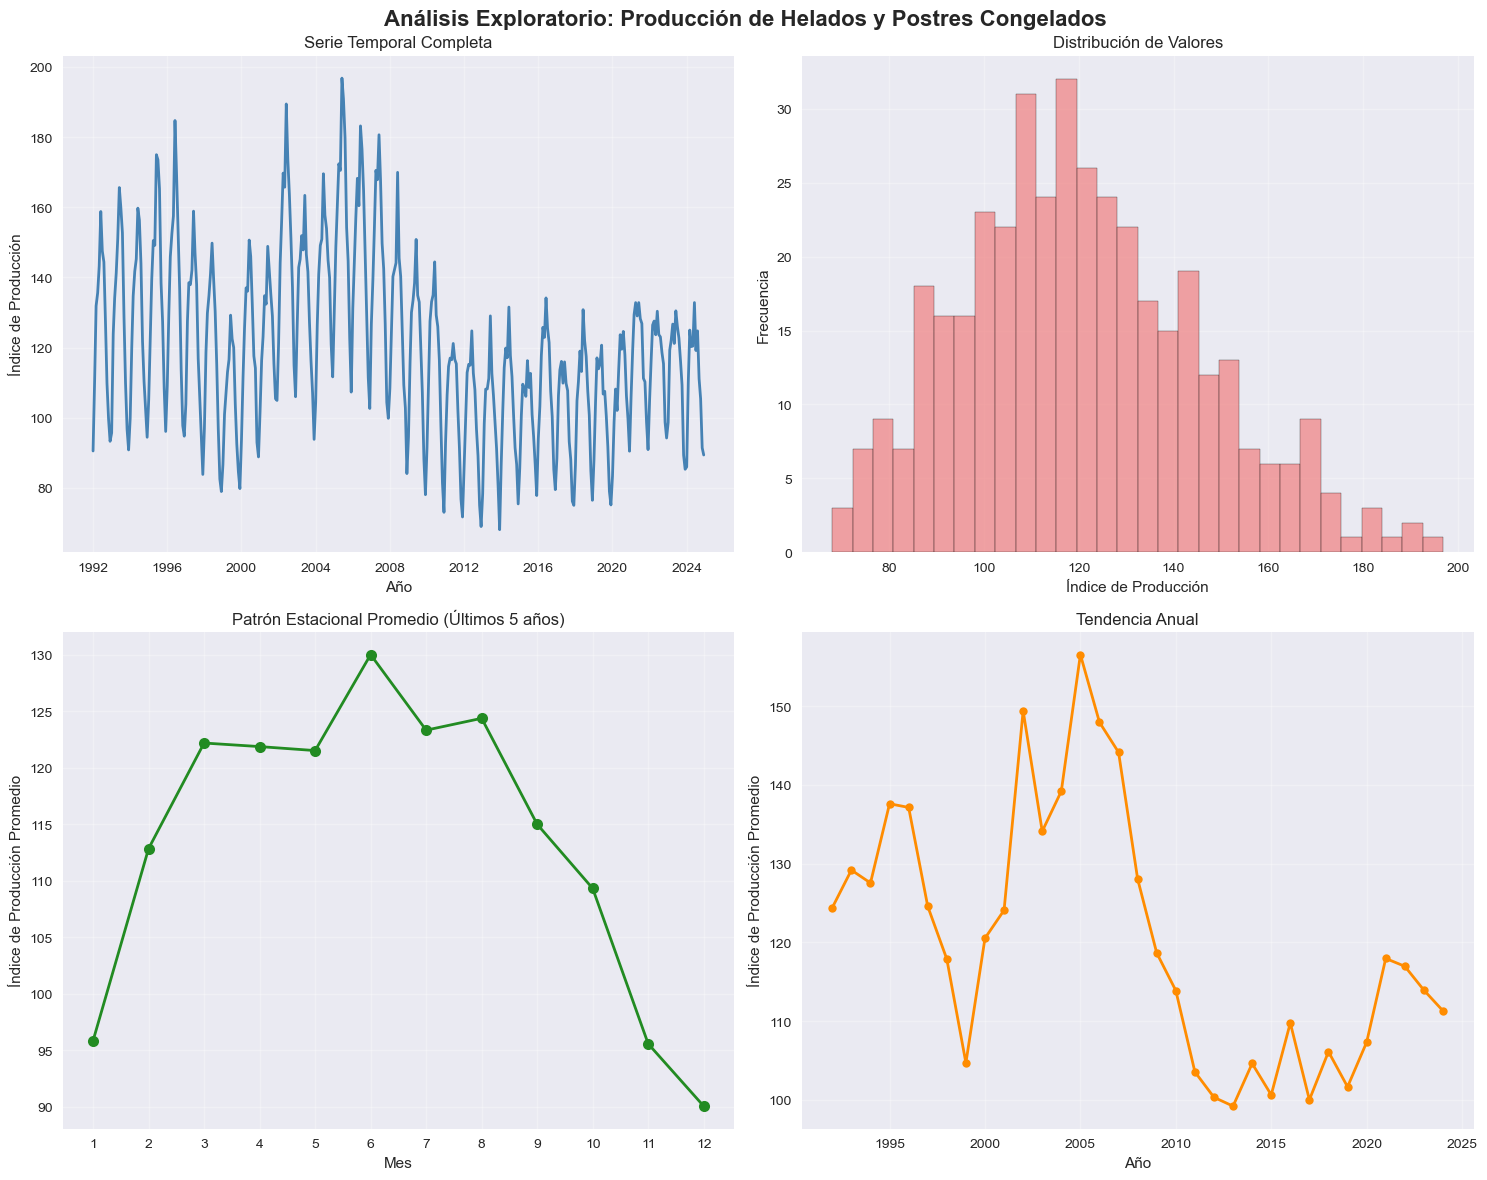

Análisis de patrones estacionales:
     Promedio  Desv. Estándar
Mes                          
1       99.47           14.30
2      117.30           14.60
3      128.73           15.33
4      134.01           19.01
5      134.24           18.66
6      148.60           23.43
7      138.67           23.03
8      133.28           19.29
9      119.55           16.62
10     108.75           15.02
11      94.76           12.82
12      87.27           11.85

Interpretación estacional:
- Mes con mayor producción promedio: Jun (148.60)
- Mes con menor producción promedio: Dic (87.27)


In [22]:
print("2. VISUALIZACIÓN EXPLORATORIA")
print("-" * 40)

# Crear figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análisis Exploratorio: Producción de Helados y Postres Congelados', fontsize=16, fontweight='bold')

# Gráfico 1: Serie temporal completa
axes[0,0].plot(df.index, df.iloc[:,0], linewidth=2, color='steelblue')
axes[0,0].set_title('Serie Temporal Completa')
axes[0,0].set_xlabel('Año')
axes[0,0].set_ylabel('Índice de Producción')
axes[0,0].grid(True, alpha=0.3)

# Gráfico 2: Distribución de valores
axes[0,1].hist(df.iloc[:,0], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_title('Distribución de Valores')
axes[0,1].set_xlabel('Índice de Producción')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].grid(True, alpha=0.3)

# Gráfico 3: Patrón estacional (últimos 5 años)
recent_data = df.last('60M')  # Últimos 5 años
monthly_avg = recent_data.groupby(recent_data.index.month).mean()
axes[1,0].plot(monthly_avg.index, monthly_avg.iloc[:,0], 'o-', linewidth=2, markersize=8, color='forestgreen')
axes[1,0].set_title('Patrón Estacional Promedio (Últimos 5 años)')
axes[1,0].set_xlabel('Mes')
axes[1,0].set_ylabel('Índice de Producción Promedio')
axes[1,0].set_xticks(range(1, 13))
axes[1,0].grid(True, alpha=0.3)

# Gráfico 4: Tendencia anual
annual_avg = df.groupby(df.index.year).mean()
axes[1,1].plot(annual_avg.index, annual_avg.iloc[:,0], 'o-', linewidth=2, markersize=6, color='darkorange')
axes[1,1].set_title('Tendencia Anual')
axes[1,1].set_xlabel('Año')
axes[1,1].set_ylabel('Índice de Producción Promedio')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de estacionalidad por mes
print("Análisis de patrones estacionales:")
seasonal_stats = df.groupby(df.index.month).agg(['mean', 'std']).round(2)
seasonal_stats.columns = ['Promedio', 'Desv. Estándar']
seasonal_stats.index.name = 'Mes'
print(seasonal_stats)

# Crear nombres de meses para mejor interpretación
month_names = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
               'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
seasonal_stats.index = month_names

print("\nInterpretación estacional:")
max_month = seasonal_stats['Promedio'].idxmax()
min_month = seasonal_stats['Promedio'].idxmin()
print(f"- Mes con mayor producción promedio: {max_month} ({seasonal_stats.loc[max_month, 'Promedio']:.2f})")
print(f"- Mes con menor producción promedio: {min_month} ({seasonal_stats.loc[min_month, 'Promedio']:.2f})")

3. DIVISIÓN DE CONJUNTOS DE DATOS
----------------------------------------
Conjunto de entrenamiento:
- Período: 1992-01-01 a 2022-12-01
- Observaciones: 372

Conjunto de prueba:
- Período: 2023-01-01 a 2024-12-01
- Observaciones: 24

Porcentajes:
- Entrenamiento: 93.9%
- Prueba: 6.1%


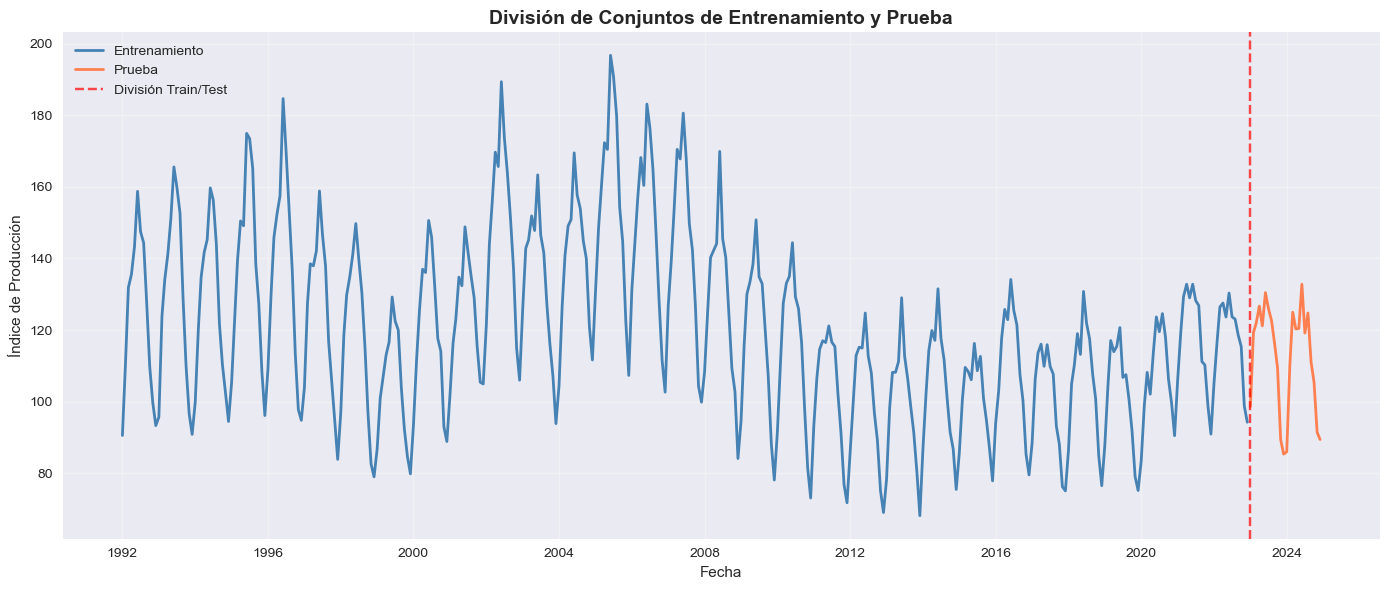

División de datos completada


In [23]:
print("3. DIVISIÓN DE CONJUNTOS DE DATOS")
print("-" * 40)

# Preparar los datos
data = df.iloc[:,0].values.reshape(-1, 1)
dates = df.index

# División: últimos 24 meses para prueba (como especifica el laboratorio)
test_size = 24
train_size = len(data) - test_size

train_data = data[:train_size]
test_data = data[train_size:]
train_dates = dates[:train_size]
test_dates = dates[train_size:]

print(f"Conjunto de entrenamiento:")
print(f"- Período: {train_dates[0].strftime('%Y-%m-%d')} a {train_dates[-1].strftime('%Y-%m-%d')}")
print(f"- Observaciones: {len(train_data)}")

print(f"\nConjunto de prueba:")
print(f"- Período: {test_dates[0].strftime('%Y-%m-%d')} a {test_dates[-1].strftime('%Y-%m-%d')}")
print(f"- Observaciones: {len(test_data)}")

print(f"\nPorcentajes:")
print(f"- Entrenamiento: {len(train_data)/len(data)*100:.1f}%")
print(f"- Prueba: {len(test_data)/len(data)*100:.1f}%")


# Visualizar la división
plt.figure(figsize=(14, 6))
plt.plot(train_dates, train_data, label='Entrenamiento', color='steelblue', linewidth=2)
plt.plot(test_dates, test_data, label='Prueba', color='coral', linewidth=2)
plt.axvline(x=test_dates[0], color='red', linestyle='--', alpha=0.7, label='División Train/Test')
plt.title('División de Conjuntos de Entrenamiento y Prueba', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Índice de Producción')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("División de datos completada")

4. NORMALIZACIÓN Y PREPARACIÓN DE DATOS
----------------------------------------
Normalización aplicada usando MinMaxScaler
Rango original entrenamiento: [68.06, 196.82]
Rango escalado entrenamiento: [0.00, 1.00]
Rango original prueba: [85.28, 132.82]
Rango escalado prueba: [0.13, 0.50]


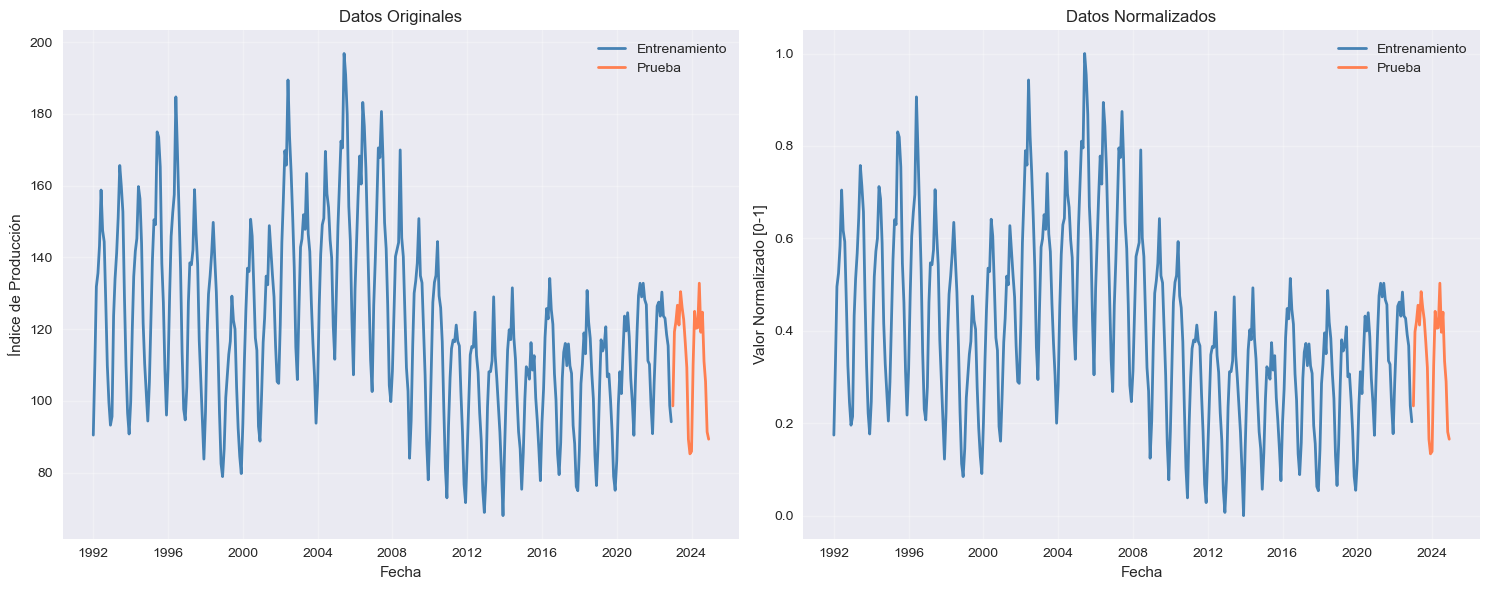

Configuración del TimeSeriesGenerator:
- Longitud de secuencia: 12 meses
- Tamaño de batch: 16
- Número de batches de entrenamiento: 23
- Número de batches de validación: 5
- Forma de entrada (X): (16, 12, 1)
- Forma de salida (y): (16, 1)
TimeSeriesGenerator configurado correctamente


In [24]:
print("4. NORMALIZACIÓN Y PREPARACIÓN DE DATOS")
print("-" * 40)

# Aplicar normalización MinMax
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

print("Normalización aplicada usando MinMaxScaler")
print(f"Rango original entrenamiento: [{train_data.min():.2f}, {train_data.max():.2f}]")
print(f"Rango escalado entrenamiento: [{train_scaled.min():.2f}, {train_scaled.max():.2f}]")
print(f"Rango original prueba: [{test_data.min():.2f}, {test_data.max():.2f}]")
print(f"Rango escalado prueba: [{test_scaled.min():.2f}, {test_scaled.max():.2f}]")

# Visualizar el efecto de la normalización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Datos originales
ax1.plot(train_dates, train_data, label='Entrenamiento', color='steelblue', linewidth=2)
ax1.plot(test_dates, test_data, label='Prueba', color='coral', linewidth=2)
ax1.set_title('Datos Originales')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Índice de Producción')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Datos normalizados
ax2.plot(train_dates, train_scaled, label='Entrenamiento', color='steelblue', linewidth=2)
ax2.plot(test_dates, test_scaled, label='Prueba', color='coral', linewidth=2)
ax2.set_title('Datos Normalizados')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Valor Normalizado [0-1]')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Configuración del TimeSeriesGenerator
sequence_length = 12  # Usar 12 meses para predecir el siguiente (1 año de contexto)
batch_size = 16

print(f"Configuración del TimeSeriesGenerator:")
print(f"- Longitud de secuencia: {sequence_length} meses")
print(f"- Tamaño de batch: {batch_size}")

# Crear el TimeSeriesGenerator para entrenamiento
train_generator = TimeseriesGenerator(
    data=train_scaled,
    targets=train_scaled,
    length=sequence_length,
    batch_size=batch_size,
    shuffle=True  # Shuffle para mejor entrenamiento
)

# Crear el TimeSeriesGenerator para validación (últimos datos de entrenamiento)
val_split = int(len(train_scaled) * 0.8)  # 80% para entrenamiento, 20% para validación
val_data = train_scaled[val_split-sequence_length:]

val_generator = TimeseriesGenerator(
    data=val_data,
    targets=val_data,
    length=sequence_length,
    batch_size=batch_size,
    shuffle=False  # No shuffle para validación
)

print(f"- Número de batches de entrenamiento: {len(train_generator)}")
print(f"- Número de batches de validación: {len(val_generator)}")

# Verificar la forma de los datos
sample_batch = train_generator[0]
print(f"- Forma de entrada (X): {sample_batch[0].shape}")
print(f"- Forma de salida (y): {sample_batch[1].shape}")

print("TimeSeriesGenerator configurado correctamente")

In [25]:
print("5. CONSTRUCCIÓN DEL MODELO LSTM")
print("-" * 40)

# Configurar semilla para reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

# Definir la arquitectura del modelo
model = Sequential([
    # Primera capa LSTM con dropout para regularización
    LSTM(units=100, 
         return_sequences=True,  # True porque tenemos otra capa LSTM después
         input_shape=(sequence_length, 1),
         dropout=0.2,           # Dropout en las conexiones de entrada
         recurrent_dropout=0.2), # Dropout en las conexiones recurrentes
    
    # Segunda capa LSTM
    LSTM(units=50, 
         return_sequences=False, # False porque es la última capa LSTM
         dropout=0.2,
         recurrent_dropout=0.2),
    
    # Capa de regularización adicional
    Dropout(0.3),
    
    # Capa densa intermedia con activación ReLU
    Dense(units=25, activation='relu'),
    
    # Otra capa de regularización
    Dropout(0.2),
    
    # Capa de salida (predicción final)
    Dense(units=1, activation='linear')  # Linear para regresión
])


# Compilar el modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',      # Mean Squared Error para regresión
    metrics=['mae']  # Mean Absolute Error como métrica adicional
)

print("Arquitectura del modelo LSTM:")
model.summary()

print(f"\nParámetros del modelo:")
print(f"- Total de parámetros: {model.count_params():,}")


5. CONSTRUCCIÓN DEL MODELO LSTM
----------------------------------------
Arquitectura del modelo LSTM:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 12, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,301 (282.43 KB)

 Trainable params: 72,301 (282.43 KB)

 Non-trainable params: 0 (0.00 B)


Parámetros del modelo:
- Total de parámetros: 72,301


In [26]:
print("6. CONFIGURACIÓN DE CALLBACKS PARA ENTRENAMIENTO")
print("-" * 40)

# Configurar callbacks para optimizar el entrenamiento
early_stopping = EarlyStopping(
    monitor='val_loss',        # Métrica a monitorear
    patience=15,               # Épocas a esperar sin mejora
    restore_best_weights=True, # Restaurar mejores pesos
    verbose=1                  # Mostrar cuando se activa
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',        # Métrica a monitorear
    factor=0.5,               # Factor de reducción (lr = lr * factor)
    patience=8,               # Épocas a esperar antes de reducir lr
    min_lr=1e-7,              # Learning rate mínimo
    verbose=1                 # Mostrar cuando se activa
)

callbacks = [early_stopping, reduce_lr]

print("\n6. ENTRENAMIENTO DEL MODELO")

# Entrenar el modelo
history = model.fit(
    train_generator,           # Datos de entrenamiento
    epochs=100,               # Máximo de épocas
    validation_data=val_generator, # Datos de validación
    callbacks=callbacks,      # Callbacks configurados
    verbose=1,               # Mostrar progreso
    shuffle=False            # Ya está shuffle en el generator
)

print("\n" + "="*50)
print("✓ ENTRENAMIENTO COMPLETADO")
print("="*50)

# Mostrar información del entrenamiento
epochs_trained = len(history.history['loss'])
print(f"- Épocas entrenadas: {epochs_trained}")
print(f"- Tiempo total: Varios minutos")
print(f"- Mejor val_loss: {min(history.history['val_loss']):.6f}")

6. CONFIGURACIÓN DE CALLBACKS PARA ENTRENAMIENTO
----------------------------------------

6. ENTRENAMIENTO DEL MODELO
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0797 - mae: 0.2303 - val_loss: 0.0150 - val_mae: 0.1044 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0528 - mae: 0.1847 - val_loss: 0.0166 - val_mae: 0.1017 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0418 - mae: 0.1638 - val_loss: 0.0168 - val_mae: 0.1018 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0418 - mae: 0.1646 - val_loss: 0.0171 - val_mae: 0.1020 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0412 - mae: 0.1602 - val_loss: 0.0170 - val_mae: 0.1019 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0417 - mae: 0.1615 - val_loss: 0.0172 - val_mae: 0.1017 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━

ANÁLISIS DE CURVAS DE ENTRENAMIENTO
----------------------------------------


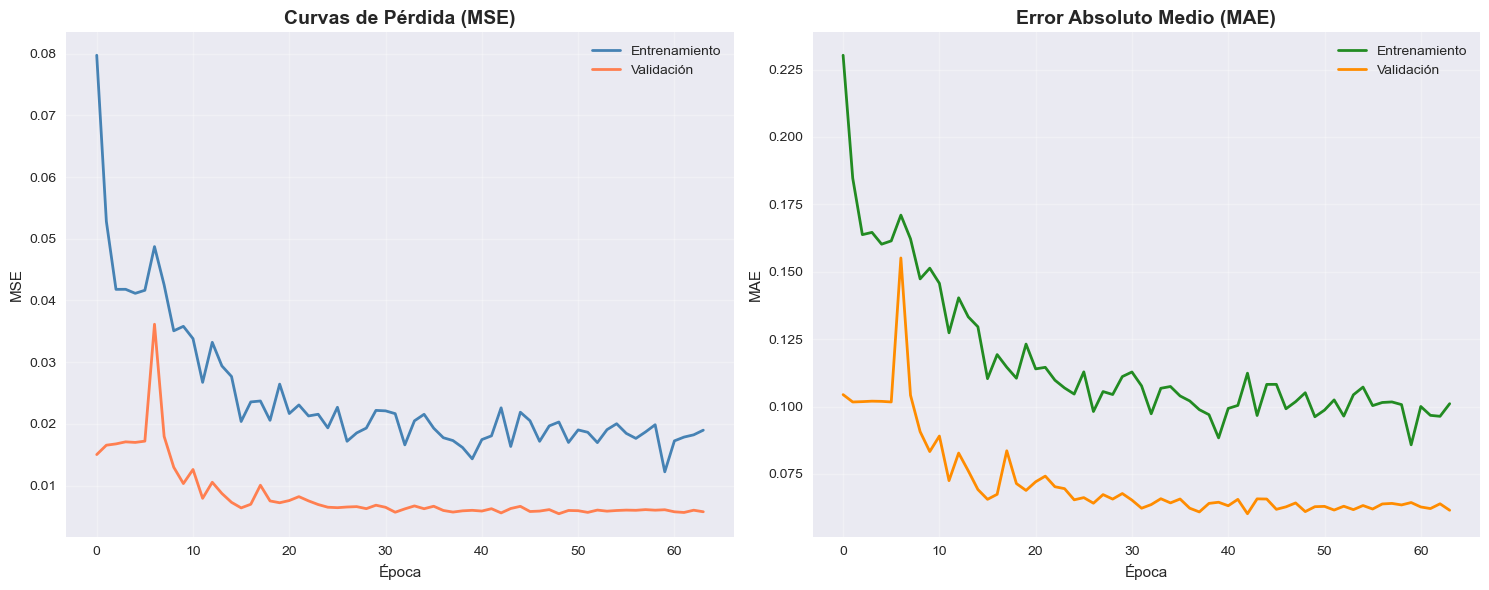

Métricas finales de entrenamiento:
- MSE entrenamiento: 0.018993
- MSE validación: 0.005772
- MAE entrenamiento: 0.101064
- MAE validación: 0.061529
- Épocas entrenadas: 64
No se detecta overfitting significativo
8. PREPARACIÓN PARA PREDICCIONES
----------------------------------------
Función de predicción secuencial definida
  - Predice paso a paso utilizando predicciones anteriores
  - Mantiene ventana deslizante de sequence_length
  - Actualiza secuencia con cada nueva predicción


In [27]:
print("ANÁLISIS DE CURVAS DE ENTRENAMIENTO")
print("-" * 40)

# Visualizar curvas de pérdida y métricas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Pérdida (MSE)
ax1.plot(history.history['loss'], label='Entrenamiento', linewidth=2, color='steelblue')
ax1.plot(history.history['val_loss'], label='Validación', linewidth=2, color='coral')
ax1.set_title('Curvas de Pérdida (MSE)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Época')
ax1.set_ylabel('MSE')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Error Absoluto Medio (MAE)
ax2.plot(history.history['mae'], label='Entrenamiento', linewidth=2, color='forestgreen')
ax2.plot(history.history['val_mae'], label='Validación', linewidth=2, color='darkorange')
ax2.set_title('Error Absoluto Medio (MAE)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Época')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas del entrenamiento
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_mae = history.history['mae'][-1]
final_val_mae = history.history['val_mae'][-1]

print(f"Métricas finales de entrenamiento:")
print(f"- MSE entrenamiento: {final_train_loss:.6f}")
print(f"- MSE validación: {final_val_loss:.6f}")
print(f"- MAE entrenamiento: {final_train_mae:.6f}")
print(f"- MAE validación: {final_val_mae:.6f}")
print(f"- Épocas entrenadas: {len(history.history['loss'])}")

if final_val_loss > final_train_loss * 1.5:
    print("Posible overfitting detectado (val_loss >> train_loss)")
else:
    print("No se detecta overfitting significativo")

print("8. PREPARACIÓN PARA PREDICCIONES")
print("-" * 40)

def predict_sequence(model, last_sequence, n_steps, scaler):
    predictions = []
    current_sequence = last_sequence.copy()
    
    for step in range(n_steps):
        # Predecir siguiente valor
        # Reshape para que coincida con input del modelo: (1, sequence_length, 1)
        next_pred = model.predict(current_sequence.reshape(1, sequence_length, 1), verbose=0)
        predictions.append(next_pred[0, 0])
        
        # Actualizar secuencia: eliminar primer valor y agregar predicción
        current_sequence = np.append(current_sequence[1:], next_pred[0, 0])
        
        # Mostrar progreso cada 5 pasos
        if (step + 1) % 5 == 0:
            print(f"  Predicción {step + 1}/{n_steps} completada")
    
    return np.array(predictions)

print("Función de predicción secuencial definida")
print("  - Predice paso a paso utilizando predicciones anteriores")
print("  - Mantiene ventana deslizante de sequence_length")
print("  - Actualiza secuencia con cada nueva predicción")

In [28]:
print("\n8. GENERACIÓN DE PREDICCIONES")
print("-" * 40)

# Obtener la última secuencia de entrenamiento para iniciar predicciones
last_sequence = train_scaled[-sequence_length:]
print(f"Última secuencia de entrenamiento: {len(last_sequence)} valores")
print(f"Rango de la secuencia: [{last_sequence.min():.3f}, {last_sequence.max():.3f}]")

print(f"\nGenerando predicciones para {len(test_data)} meses...")

# Hacer predicciones para el conjunto de prueba
test_predictions_scaled = predict_sequence(model, last_sequence, len(test_data), scaler)

# Desnormalizar predicciones para obtener valores en escala original
test_predictions = scaler.inverse_transform(test_predictions_scaled.reshape(-1, 1)).flatten()

print(f"\n✓ Predicciones generadas exitosamente")
print(f"- Valores predichos: {len(test_predictions)}")
print(f"- Rango de predicciones: [{test_predictions.min():.2f}, {test_predictions.max():.2f}]")
print(f"- Rango de valores reales: [{test_data.min():.2f}, {test_data.max():.2f}]")

print("9. EVALUACIÓN DEL MODELO")
print("-" * 40)

# Calcular métricas de evaluación estándar
mse = mean_squared_error(test_data.flatten(), test_predictions)
mae = mean_absolute_error(test_data.flatten(), test_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test_data.flatten(), test_predictions)

# Calcular error porcentual absoluto medio (MAPE)
mape = np.mean(np.abs((test_data.flatten() - test_predictions) / test_data.flatten())) * 100

# Calcular error porcentual medio (MPE) para ver sesgo
mpe = np.mean((test_data.flatten() - test_predictions) / test_data.flatten()) * 100

# Calcular métricas adicionales
residuals = test_data.flatten() - test_predictions
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)

print("MÉTRICAS DE EVALUACIÓN EN CONJUNTO DE PRUEBA:")
print("=" * 50)
print(f"Métricas Principales:")
print(f"   • MSE (Error Cuadrático Medio): {mse:.4f}")
print(f"   • RMSE (Raíz del ECM): {rmse:.4f}")
print(f"   • MAE (Error Absoluto Medio): {mae:.4f}")
print(f"   • R² (Coef. Determinación): {r2:.4f}")
print(f"   • MAPE (Error % Abs. Medio): {mape:.2f}%")
print(f"   • MPE (Error % Medio): {mpe:.2f}%")

print(f"\nAnálisis de Residuos:")
print(f"   • Media de residuos: {mean_residual:.4f}")
print(f"   • Desv. estándar residuos: {std_residual:.4f}")
print(f"   • Residuo mínimo: {residuals.min():.4f}")
print(f"   • Residuo máximo: {residuals.max():.4f}")


8. GENERACIÓN DE PREDICCIONES
----------------------------------------
Última secuencia de entrenamiento: 12 valores
Rango de la secuencia: [0.203, 0.484]

Generando predicciones para 24 meses...
  Predicción 5/24 completada
  Predicción 10/24 completada
  Predicción 15/24 completada
  Predicción 20/24 completada

✓ Predicciones generadas exitosamente
- Valores predichos: 24
- Rango de predicciones: [100.60, 117.24]
- Rango de valores reales: [85.28, 132.82]
9. EVALUACIÓN DEL MODELO
----------------------------------------
MÉTRICAS DE EVALUACIÓN EN CONJUNTO DE PRUEBA:
Métricas Principales:
   • MSE (Error Cuadrático Medio): 136.7911
   • RMSE (Raíz del ECM): 11.6958
   • MAE (Error Absoluto Medio): 10.6672
   • R² (Coef. Determinación): 0.3620
   • MAPE (Error % Abs. Medio): 9.65%
   • MPE (Error % Medio): 2.71%

Análisis de Residuos:
   • Media de residuos: 4.5256
   • Desv. estándar residuos: 10.7847
   • Residuo mínimo: -16.6023
   • Residuo máximo: 21.6727



10. VISUALIZACIÓN DE RESULTADOS
----------------------------------------


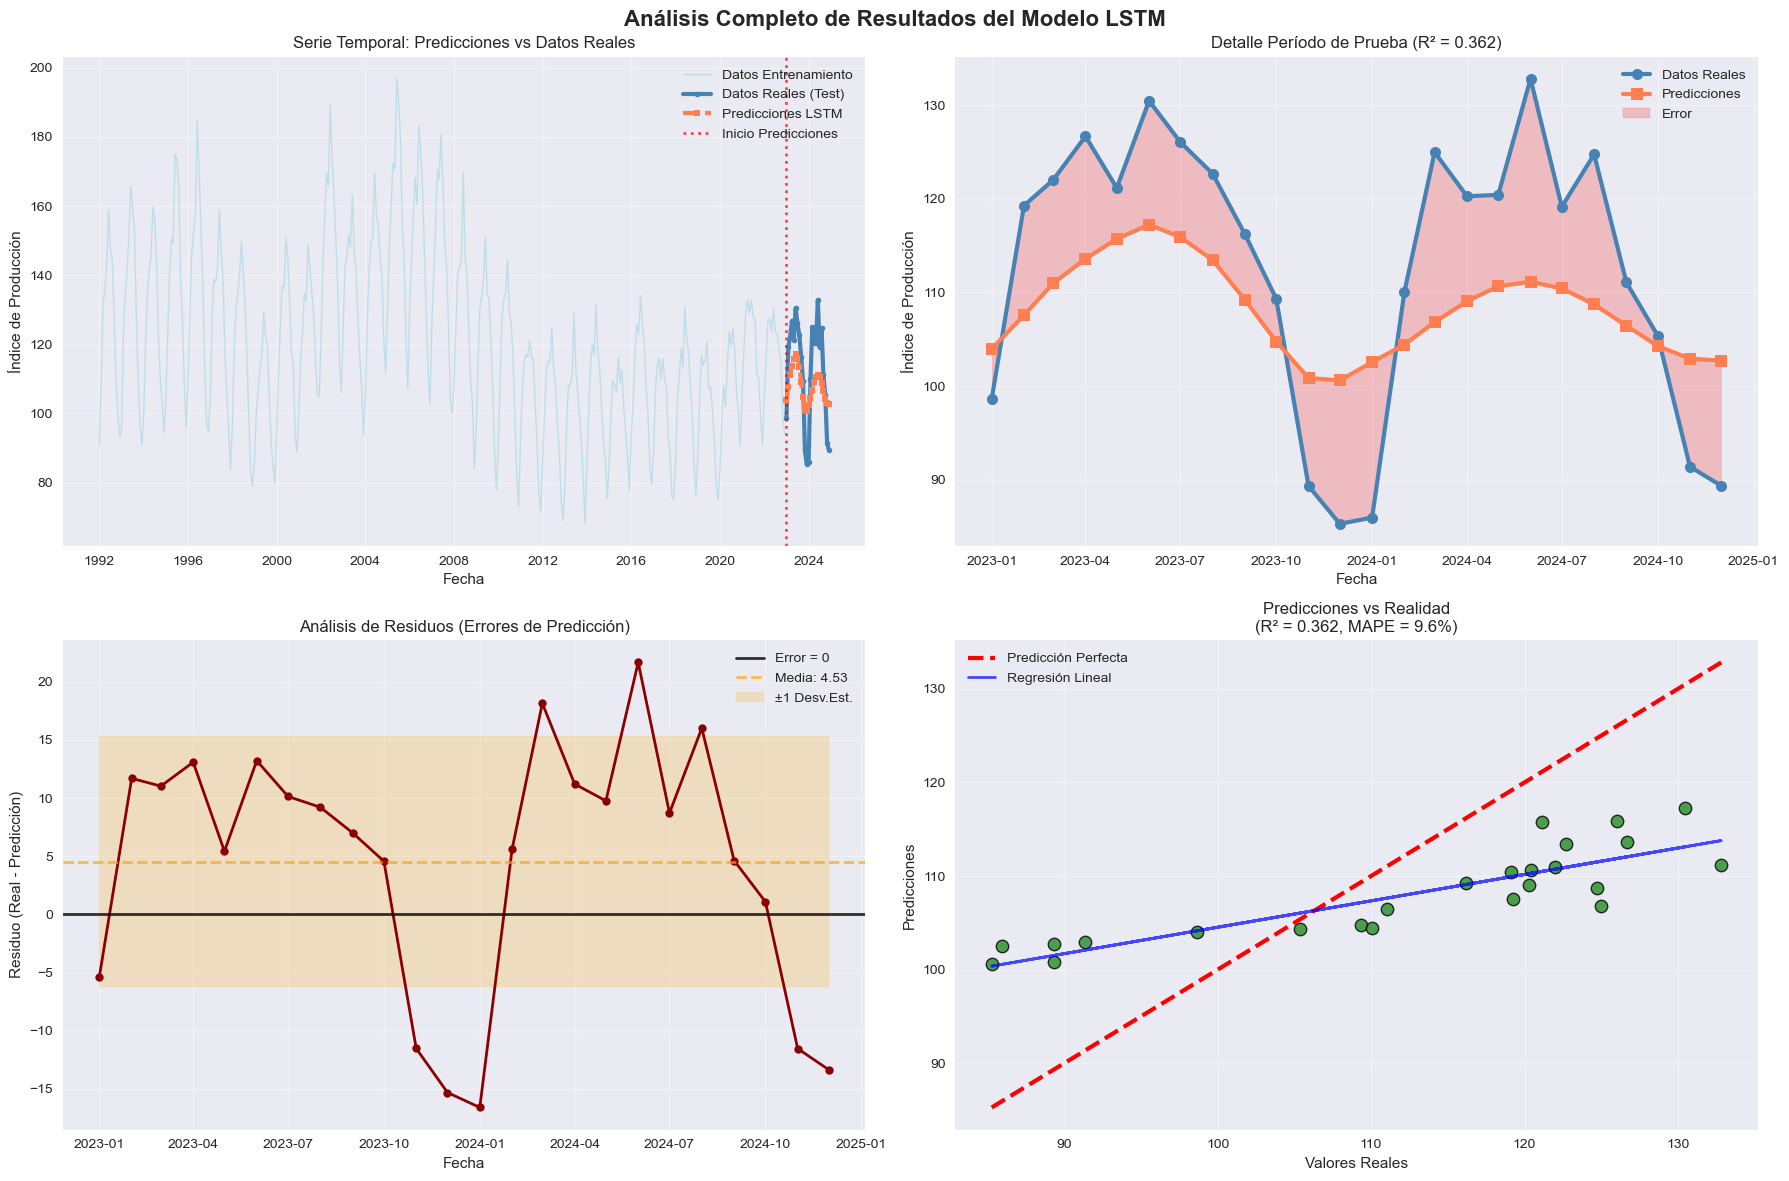

In [29]:
print("\n10. VISUALIZACIÓN DE RESULTADOS")
print("-" * 40)

# Crear visualización comprehensiva con 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Análisis Completo de Resultados del Modelo LSTM', fontsize=16, fontweight='bold')

# Gráfico 1: Serie temporal completa con predicciones
axes[0,0].plot(train_dates, train_data.flatten(), label='Datos Entrenamiento', 
               color='lightblue', alpha=0.7, linewidth=1)
axes[0,0].plot(test_dates, test_data.flatten(), label='Datos Reales (Test)', 
               color='steelblue', linewidth=3, marker='o', markersize=4)
axes[0,0].plot(test_dates, test_predictions, label='Predicciones LSTM', 
               color='coral', linewidth=3, linestyle='--', marker='s', markersize=4)
axes[0,0].axvline(x=test_dates[0], color='red', linestyle=':', alpha=0.7, 
                  label='Inicio Predicciones', linewidth=2)
axes[0,0].set_title('Serie Temporal: Predicciones vs Datos Reales')
axes[0,0].set_xlabel('Fecha')
axes[0,0].set_ylabel('Índice de Producción')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Gráfico 2: Zoom en período de prueba
axes[0,1].plot(test_dates, test_data.flatten(), 'o-', label='Datos Reales', 
               color='steelblue', linewidth=3, markersize=8)
axes[0,1].plot(test_dates, test_predictions, 's-', label='Predicciones', 
               color='coral', linewidth=3, markersize=8)
# Agregar barras de error
axes[0,1].fill_between(test_dates, test_data.flatten(), test_predictions, 
                       alpha=0.2, color='red', label='Error')
axes[0,1].set_title(f'Detalle Período de Prueba (R² = {r2:.3f})')
axes[0,1].set_xlabel('Fecha')
axes[0,1].set_ylabel('Índice de Producción')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Gráfico 3: Análisis de residuos
axes[1,0].plot(test_dates, residuals, 'o-', color='darkred', linewidth=2, markersize=6)
axes[1,0].axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=2, label='Error = 0')
axes[1,0].axhline(y=mean_residual, color='orange', linestyle='--', alpha=0.7, linewidth=2,
                  label=f'Media: {mean_residual:.2f}')
axes[1,0].fill_between(test_dates, mean_residual - std_residual, mean_residual + std_residual, 
                       alpha=0.2, color='orange', label=f'±1 Desv.Est.')
axes[1,0].set_title('Análisis de Residuos (Errores de Predicción)')
axes[1,0].set_xlabel('Fecha')
axes[1,0].set_ylabel('Residuo (Real - Predicción)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Gráfico 4: Diagrama de dispersión con línea de regresión
axes[1,1].scatter(test_data.flatten(), test_predictions, alpha=0.8, color='forestgreen', 
                  s=80, edgecolors='black', linewidth=1)
# Línea diagonal perfecta
min_val = min(test_data.min(), test_predictions.min())
max_val = max(test_data.max(), test_predictions.max())
axes[1,1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=3, 
               label='Predicción Perfecta')
# Línea de regresión real
z = np.polyfit(test_data.flatten(), test_predictions, 1)
p = np.poly1d(z)
axes[1,1].plot(test_data.flatten(), p(test_data.flatten()), 'b-', linewidth=2, 
               alpha=0.7, label='Regresión Lineal')
axes[1,1].set_title(f'Predicciones vs Realidad\n(R² = {r2:.3f}, MAPE = {mape:.1f}%)')
axes[1,1].set_xlabel('Valores Reales')
axes[1,1].set_ylabel('Predicciones')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

